In [2]:

import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pandas.plotting import lag_plot

[*********************100%***********************]  1 of 1 completed


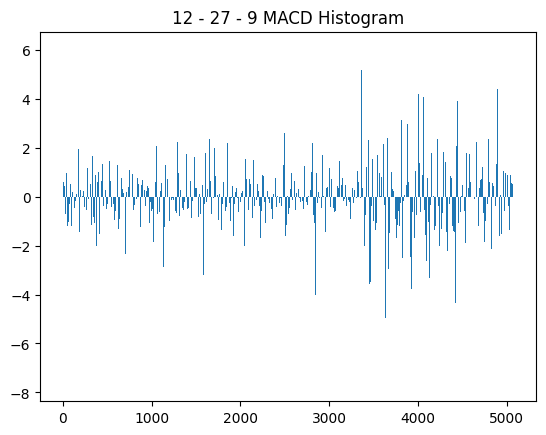

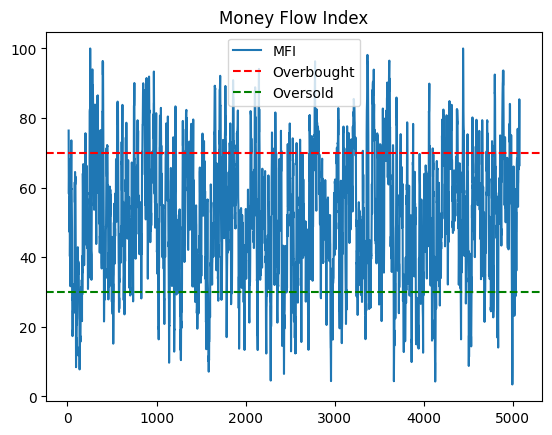

                            OLS Regression Results                            
Dep. Variable:      3 Period % Change   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.139
Date:                Tue, 21 Oct 2025   Prob (F-statistic):              0.337
Time:                        22:56:22   Log-Likelihood:                 3831.0
No. Observations:                1677   AIC:                            -7652.
Df Residuals:                    1672   BIC:                            -7625.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.005      0.631      0.5

Price,Adj Close,Close,High,Low,Open,Volume,12_ema,27_ema,MACD,Signal,...,BB_SMA,BB_STD,Upper_Band,Lower_Band,BB,RSI,Close + 3,3 Period % Change,Predictions,Residuals
0,195.296295,195.296295,196.250000,191.600006,191.779999,24303778,192.365246,188.850934,3.514312,3.007521,...,188.316711,6.347304,201.011319,175.622104,0.225097,80.429740,191.793793,-0.017934,-0.000074,0.017861
1,191.793793,191.793793,192.869095,191.110001,192.203003,6898755,192.331973,189.561106,2.770867,3.005093,...,189.992606,5.633554,201.259713,178.725498,0.420069,70.171280,194.850006,0.015935,0.000071,-0.015864
2,194.850006,194.850006,194.970001,193.699997,194.572601,6906754,193.029531,190.471460,2.558070,2.792020,...,191.800856,4.477947,200.756751,182.844961,0.329769,50.512571,184.080002,-0.055273,0.001419,0.056692
3,184.080002,184.080002,185.470001,183.699997,185.320007,9074017,189.758576,189.313483,0.445093,1.909252,...,192.221397,3.523420,199.268236,185.174557,1.077663,24.802287,181.119995,-0.016080,-0.001172,0.014908
4,181.119995,181.119995,182.330002,180.760101,182.330002,9860904,186.757941,187.878972,-1.121031,0.639619,...,190.772436,5.034726,200.841889,180.702983,0.979293,22.130669,179.330002,-0.009883,-0.000710,0.009173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1673,436.559998,436.559998,439.049988,434.895813,438.670013,7586702,433.431109,432.440517,0.990593,0.377831,...,433.063264,4.506862,442.076988,424.049541,0.306033,57.681728,439.269989,0.006208,0.002516,-0.003692
1674,439.269989,439.269989,439.899994,437.649994,439.429993,6909285,435.776005,433.825337,1.950669,1.042926,...,433.919014,4.788764,443.496543,424.341485,0.220649,54.255037,444.160004,0.011132,0.002709,-0.008423
1675,444.160004,444.160004,447.249908,441.910004,443.059998,8049449,439.079068,435.891845,3.187223,1.969554,...,435.511771,5.923708,447.359186,423.664355,0.135016,64.184164,446.570007,0.005426,0.002124,-0.003302
1676,446.570007,446.570007,446.899994,443.959991,444.484497,5876103,441.393055,437.676885,3.716170,2.727923,...,437.122807,6.745781,450.614370,423.631244,0.149885,73.768905,444.795990,-0.003973,0.002629,0.006601


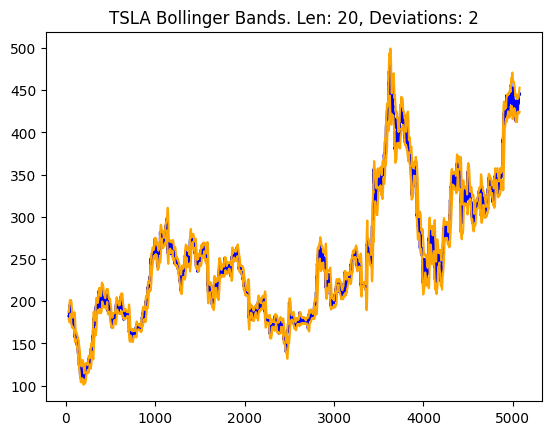

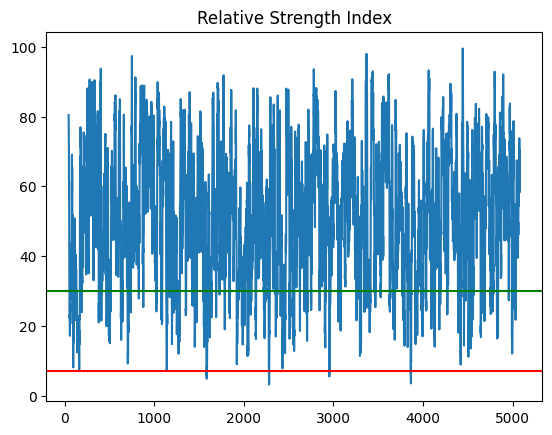

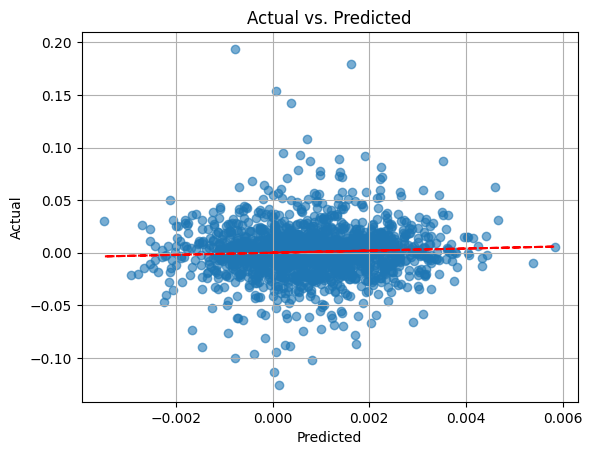

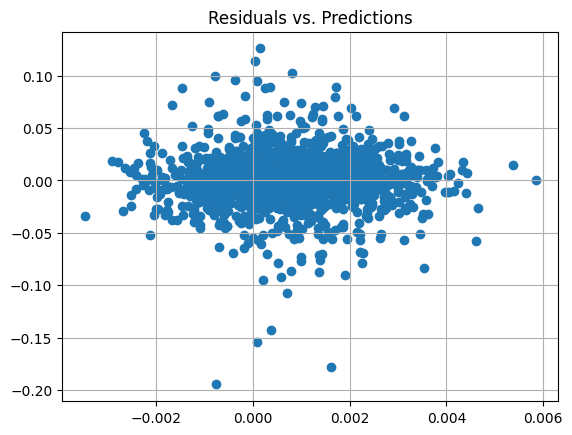

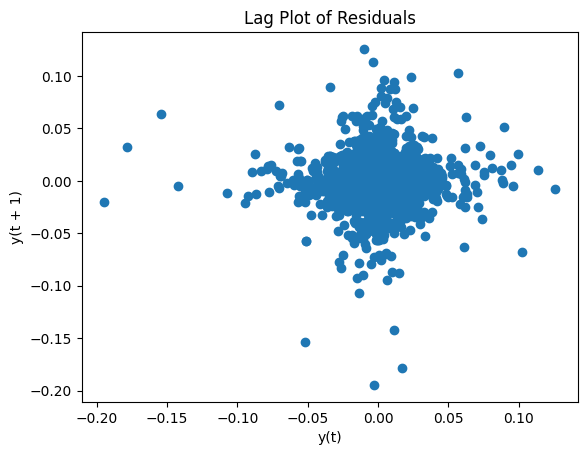

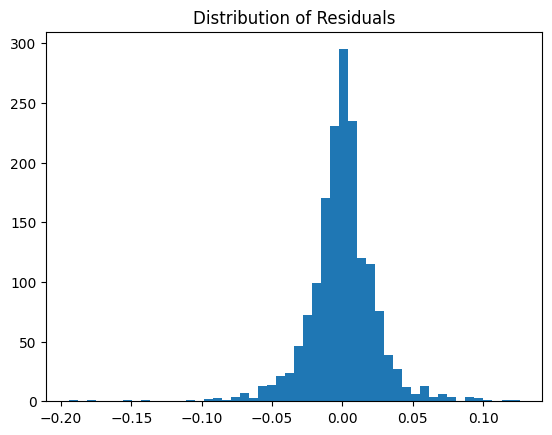

In [3]:
TICKER = 'TSLA'
INTERVAL='1h'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

SHIFT = 3
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9
MFI_LENGTH = 14
MFI_OVERBOUGHT = 70
MFI_OVERSOLD = 30
RSI_LENGTH = 14
RSI_OVERBOUGHT = 7
RSI_OVERSOLD = 30
BB_LEN = 20
DEVS = 2

# what subsetion of that data are you interested in
LOOKBACK = 10000

STRATEGY = ['MACD_hist', 'MFI', 'BB', 'RSI']

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, auto_adjust=False, period=PERIOD)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

def add_MACD(df, fast=MACD_FAST, slow=MACD_SLOW, span=MACD_SPAN):

    df[f'{fast}_ema'] = df['Close'].ewm(span=fast).mean()
    df[f'{slow}_ema'] = df['Close'].ewm(span=slow).mean()

    # macd line is the difference betweent he fast and slow
    df[f'MACD'] = df[f'{fast}_ema'] - df[f'{slow}_ema']

    # macd signal is a 9-period moving average of this line
    df['Signal'] = df['MACD'].ewm(span=span).mean()

    # MACD histogram is almost always what is used in TA
    df['MACD_hist'] = df['MACD'] - df['Signal']

    # plot the histogram
    plt.figure()
    plt.bar(x=range(len(df)), height=df['MACD_hist'])
    plt.title(f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Histogram')

    return df

def add_MFI(df, length=MFI_LENGTH, overbought=MFI_OVERBOUGHT, oversold=MFI_OVERSOLD):
    df = df.copy()

    # Step 1: Calculate typical price
    df['Typical_Price'] = (df['High'] + df['Low'] + df['Close']) / 3

    # Step 2: Calculate raw money flow
    df['Raw_Money_Flow'] = df['Typical_Price'] * df['Volume']

    # Step 3: Classify positive/negative money flow
    df['Price_Change'] = df['Typical_Price'].diff()

    df['Pos_Flow'] = np.where(df['Price_Change'] > 0, df['Raw_Money_Flow'], 0)
    df['Neg_Flow'] = np.where(df['Price_Change'] < 0, df['Raw_Money_Flow'], 0)

    # Step 4: Money Flow Ratio and MFI
    pos_sum = df['Pos_Flow'].rolling(window=length).sum()
    neg_sum = df['Neg_Flow'].rolling(window=length).sum()
    mfr = pos_sum / neg_sum
    df['MFI'] = 100 - (100 / (1 + mfr))

    # Step 5: Plot
    plt.figure()
    plt.plot(df['MFI'], label='MFI')
    plt.axhline(overbought, color='red', linestyle='--', label='Overbought')
    plt.axhline(oversold, color='green', linestyle='--', label='Oversold')
    plt.title('Money Flow Index')
    plt.legend()
    plt.show()

    return df.dropna()

def add_BB(df, devs=DEVS, bb_len=BB_LEN):

    # can change to ema (use MACD video/code for reference)
    df['BB_SMA'] = df['Close'].rolling(bb_len).mean()

    # get the standard deviation of the close prices for the period
    df['BB_STD'] = df['Close'].rolling(bb_len).std()

    df['Upper_Band'] = df['BB_SMA'] + (devs * df['BB_STD'])
    df['Lower_Band'] = df['BB_SMA'] - (devs * df['BB_STD'])

    df['BB'] = (df['Upper_Band'] - df['Close']) / (df['Upper_Band'] - df['Lower_Band'])

    df = df.dropna()

    plt.figure()
    plt.plot(df['Close'], color='blue')
    plt.plot(df['Upper_Band'], color='orange')
    plt.plot(df['Lower_Band'], color='orange')
    plt.title(f'{TICKER} Bollinger Bands. Len: {BB_LEN}, Deviations: {DEVS}');

    return df

def add_RSI(df, length=RSI_LENGTH, overbought=RSI_OVERBOUGHT, oversold=RSI_OVERSOLD):

    price_change = df['Close'].diff()
    
    # separate gains/losses
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    # average gain vs loss
    avg_gain = gain.rolling(window=length).mean()
    avg_loss = loss.rolling(window=length).mean()

    # calculate rsi
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi

    # plot the relative strength index
    plt.figure()
    plt.plot(df['RSI'])
    plt.axhline(overbought, color='red')
    plt.axhline(oversold, color='green')
    plt.title('Relative Strength Index')

    return df.dropna()

# define the target variable (also called dependent variable, or y)
def add_target(df, shift=SHIFT, interval=SHIFT):

    # what is the close price SHIFT days from now?
    df[f'Close + {shift}'] = df['Close'].shift(-shift)

    # what is the change in close price SHIFT days from now?
    df[f'{shift} Period % Change'] = (df[f'Close + {shift}'] - df['Close']) / df['Close']
    
    # fix autocorrelation within target
    df = df.iloc[::interval].reset_index(drop=True)

    return df

def generate_regression_output(df, features=STRATEGY, target=f'{SHIFT} Period % Change'):
    subset = df[features + [target]].dropna()

    X = subset[features]
    y = subset[target]

    X_with_const = sm.add_constant(X)
    model = sm.OLS(y, X_with_const).fit()

    intercept = model.params['const']
    coefficients = model.params.drop('const')
    r2 = model.rsquared
    p_values = model.pvalues.drop('const')
    model_p_value = model.f_pvalue  # overall model significance
    n_obs = len(subset)

    y_pred = model.predict(X_with_const)

    # Console summary
    print(model.summary())

    # Plot actual vs predicted
    plt.figure()
    plt.scatter(y_pred, y, alpha=0.6)
    plt.plot(y_pred, y_pred, color='red', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Actual vs. Predicted")
    plt.grid(True)

    return df, intercept, coefficients, model_p_value

def validate_regression_output(df, coef, intercept):
    df['Predictions'] = intercept
    for feature in coef.index:
        df['Predictions'] += df[feature] * coef[feature]

    df['Residuals'] = df['Predictions'] - df[f'{SHIFT} Period % Change']

    plt.figure()
    plt.scatter(df['Predictions'], df['Residuals'])
    plt.title('Residuals vs. Predictions')
    plt.grid(True)

    plt.figure()
    lag_plot(df['Residuals'].dropna())
    plt.title('Lag Plot of Residuals')

    plt.figure()
    plt.hist(df['Residuals'].dropna(), bins=50)
    plt.title('Distribution of Residuals')

    return df

def main():
    df = get_data()
    df = add_MACD(df)
    df = add_MFI(df)
    df = add_BB(df)
    df = add_RSI(df)
    df = add_target(df)
    df, fit_intercept, fit_coefficient, model_pval = generate_regression_output(df)
    df = validate_regression_output(df, coef=fit_coefficient, intercept=fit_intercept)

    print(f"\n[Overall Model Significance] p-value = {model_pval:.6f}")

    return df

df = main()
df